# Importing Libraries

In [ ]:
# import system libs
import os
import itertools
from PIL import Image # pillow

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalMaxPooling2D,Conv2D,Dropout,Flatten
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from imblearn.over_sampling import SMOTE

from tensorflow.keras import layers, models, regularizers

sns.set_style('darkgrid')

In [2]:
train_path = r"/kaggle/input/addataset2/Alzheimer_s Dataset/train"
test_path = r"/kaggle/input/addataset2/Alzheimer_s Dataset/test"
batch_s = 32
img_size= (224,224)
mode = "rgb"

CLASSES = {'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented'}

# Reading data and graphing number of images in each class

In [3]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df


In [4]:
train_df = df_maker(train_path)

In [5]:
test_df = df_maker(test_path)

In [6]:
all_data = pd.concat([train_df,test_df])

In [7]:
train_df

,file_paths,labels
0,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
1,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
2,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
3,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
4,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
...,...,...
5116,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented
5117,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented
5118,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented
5119,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented


In [8]:
test_df

,file_paths,labels
0,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
1,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
2,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
3,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
4,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
...,...,...
1274,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented
1275,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented
1276,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented
1277,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented


In [9]:
all_data

,file_paths,labels
0,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
1,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
2,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
3,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
4,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,ModerateDemented
...,...,...
1274,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented
1275,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented
1276,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented
1277,/kaggle/input/addataset2/Alzheimer_s Dataset/t...,MildDemented


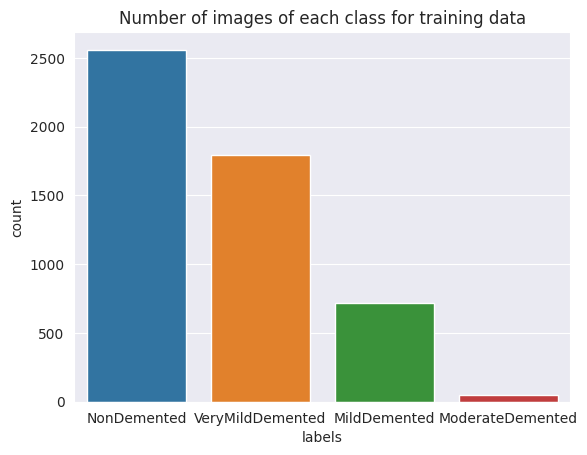

In [10]:
train_count_df = train_df.labels.value_counts().reset_index()
sns.barplot(data=train_count_df,x="labels",y="count")
plt.title("Number of images of each class for training data")
plt.show()

In [11]:
train_count_df

,labels,count
0,NonDemented,2560
1,VeryMildDemented,1792
2,MildDemented,717
3,ModerateDemented,52


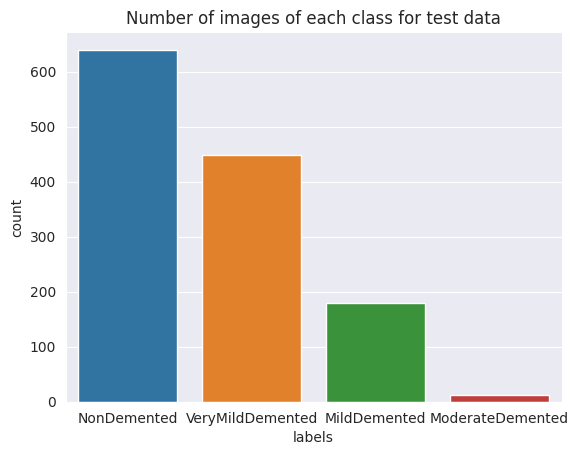

In [12]:
test_count_df = test_df.labels.value_counts().reset_index()
sns.barplot(data=test_count_df,x="labels",y="count")
plt.title("Number of images of each class for test data")
plt.show()

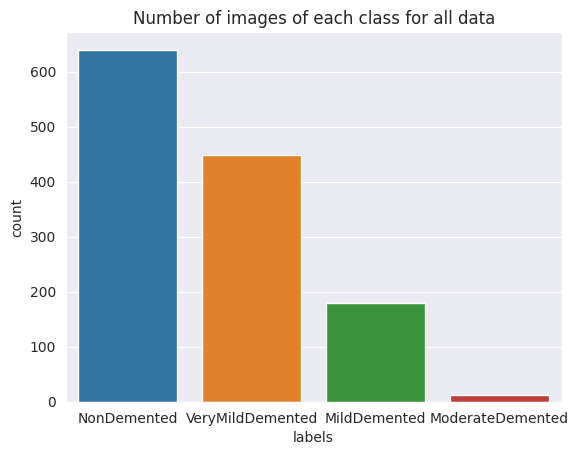

In [13]:
data_count_df = all_data.labels.value_counts().reset_index()
sns.barplot(data=test_count_df,x="labels",y="count")
plt.title("Number of images of each class for all data")
plt.show()

In [14]:
data_count_df

,labels,count
0,NonDemented,3200
1,VeryMildDemented,2240
2,MildDemented,896
3,ModerateDemented,64


#### * data is very imbalanced so we need to upsample

# Reading images and upsampling data using SMOTE

In [15]:
# latest aug

datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')



In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [17]:
data_generator = datagen.flow_from_dataframe(
    all_data,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    batch_size=batch_s,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Get the total number of samples
print(f"Total number of samples: {data_generator.n}")  
print(f"Total batches per epoch: {len(data_generator)}")  

Found 6400 validated image filenames belonging to 4 classes.
Total number of samples: 6400
Total batches per epoch: 200


In [18]:
data_generator.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

## Showing sample images from the data

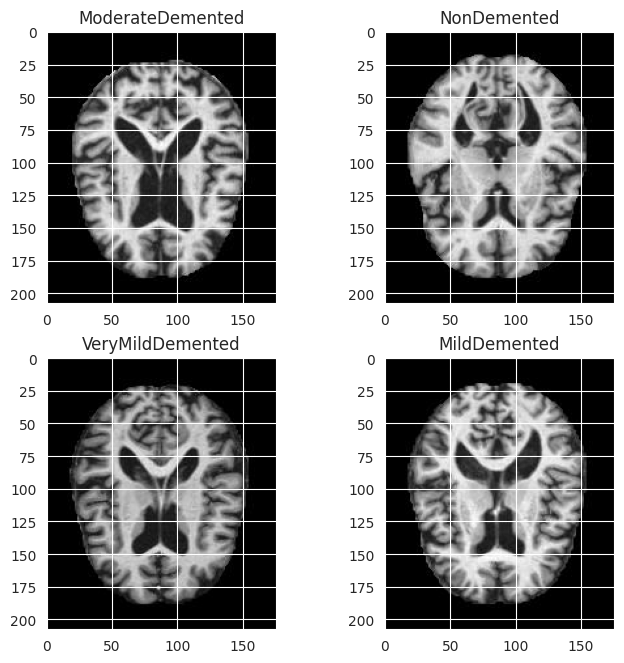

In [19]:
class_dirs = os.listdir(train_path)
plt.figure(figsize=(8, 12))
for i in range(len(class_dirs)):
    plt.subplot(3,2,i+1)
    img_path = f"{train_path}/{class_dirs[i]}/{os.listdir(f'{train_path}/{class_dirs[i]}')[0]}"
    img = plt.imread(img_path)/255
    plt.title(class_dirs[i])
    plt.imshow(img,cmap="gray")

### loading data from generator


In [20]:
data_imgs=np.concatenate([next(data_generator)[0] for i in range(data_generator.__len__())])
data_labels=np.concatenate([next(data_generator)[1] for i in range(data_generator.__len__())])

### Converting our color images to a vector and applying SMOTE method

In [21]:
data_imgs = data_imgs.reshape(-1, 224*224* 3)
data_imgs,data_labels = SMOTE(random_state=7).fit_resample(data_imgs,data_labels)
data_imgs = data_imgs.reshape(-1,224,224,3)

In [22]:
data_generator.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [23]:
map  ={0:'MildDemented',
 1:'ModerateDemented',
 2:'NonDemented',
 3:'VeryMildDemented'}

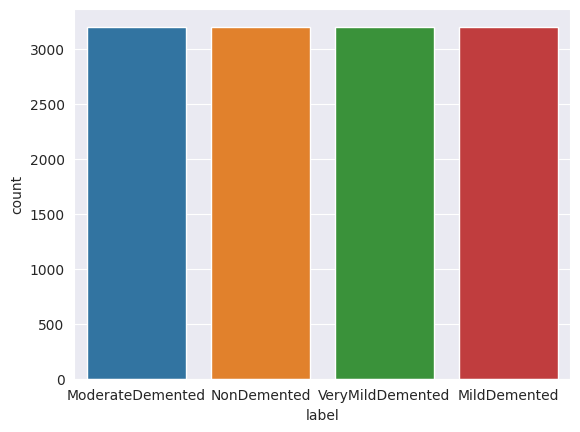

In [24]:
labels=pd.Series([map[i] for i in np.argmax(data_labels,axis=1)],name="label")
labels_count = labels.value_counts().reset_index()
sns.barplot(data=labels_count,x="label",y="count")
plt.show()

In [25]:
labels_count

,label,count
0,ModerateDemented,3200
1,NonDemented,3200
2,VeryMildDemented,3200
3,MildDemented,3200


# Splitting data into train,validation and test data

In [26]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(data_imgs,data_labels,  train_size= 0.75, shuffle= True, random_state= 7,stratify=data_labels)

In [27]:
test_imgs, val_imgs, test_labels, val_labels = train_test_split(test_imgs,test_labels,  train_size= 0.5, shuffle= True, random_state= 7,stratify= test_labels)

In [28]:
train_imgs.shape

(9600, 224, 224, 3)

In [29]:
val_imgs.shape

(1600, 224, 224, 3)

In [30]:
test_imgs.shape

(1600, 224, 224, 3)

In [31]:
import numpy as np
import pandas as pd

# Convert one-hot encoded labels to class indices using argmax
train_labels_idx = np.argmax(train_labels, axis=1)
test_labels_idx = np.argmax(test_labels, axis=1)
val_labels_idx = np.argmax(val_labels, axis=1)

# Map class indices to class names using `map` dictionary
train_count = pd.Series([map[i] for i in train_labels_idx], name="label")
test_count = pd.Series([map[i] for i in test_labels_idx], name="label")
val_count = pd.Series([map[i] for i in val_labels_idx], name="label")

# Count occurrences of each class and reset index
train_count = train_count.value_counts().reset_index()
test_count = test_count.value_counts().reset_index()
val_count = val_count.value_counts().reset_index()

# Rename columns for clarity
train_count.columns = ["Class", "Count"]
test_count.columns = ["Class", "Count"]
val_count.columns = ["Class", "Count"]

# Display results
print("Training Set Distribution:")
print(train_count)

print("\nTest Set Distribution:")
print(test_count)

print("\nValidation Set Distribution:")
print(val_count)


Training Set Distribution:
              Class  Count
0  VeryMildDemented   2400
1  ModerateDemented   2400
2       NonDemented   2400
3      MildDemented   2400

Test Set Distribution:
              Class  Count
0       NonDemented    400
1  VeryMildDemented    400
2  ModerateDemented    400
3      MildDemented    400

Validation Set Distribution:
              Class  Count
0      MildDemented    400
1  VeryMildDemented    400
2  ModerateDemented    400
3       NonDemented    400


> # SquezeNet

In [31]:
# previous


import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define SqueezeNet architecture manually
def fire_module(x, squeeze_filters, expand_filters):
    squeeze = layers.Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same')(x)
    expand_1x1 = layers.Conv2D(expand_filters, (1, 1), activation='relu', padding='same')(squeeze)
    expand_3x3 = layers.Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)
    return layers.Concatenate()([expand_1x1, expand_3x3])

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = fire_module(x, 16, 64)
x = fire_module(x, 16, 64)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = fire_module(x, 32, 128)
x = fire_module(x, 32, 128)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = fire_module(x, 48, 192)
x = fire_module(x, 48, 192)
x = fire_module(x, 64, 256)
x = fire_module(x, 64, 256)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=Adamax(learning_rate=0.001), metrics=["accuracy", "AUC"])

# Define callbacks
checkpoint = ModelCheckpoint("alzheimer's_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_imgs, train_labels,
    epochs=25,
    validation_data=(val_imgs, val_labels),
    batch_size=batch_s,
    callbacks=[checkpoint, reduce_lr]
)


In [34]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define the Fire module used in SqueezeNet
def fire_module(x, squeeze_filters, expand_filters):
    # Squeeze layer (1x1 convolutions)
    x = layers.Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Expand layer (1x1 and 3x3 convolutions)
    expand_1x1 = layers.Conv2D(expand_filters, (1, 1), activation='relu', padding='same')(x)
    expand_3x3 = layers.Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(x)

    # Concatenate the outputs of 1x1 and 3x3 convolutions
    x = layers.Concatenate(axis=-1)([expand_1x1, expand_3x3])
    return x

# Define the SqueezeNet architecture
def build_squeezenet(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Fire modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)

    # Final layers
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(4, (1, 1), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Softmax()(x)

    # Create the model
    model = Model(inputs, outputs)
    return model

# Build the SqueezeNet model
base_model = build_squeezenet(input_shape=(224, 224, 3))

# Add custom layers on top of SqueezeNet
x = base_model.output
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.4)(x)
predictions = layers.Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=Adamax(learning_rate=0.001), metrics=["accuracy", "AUC"])


In [ ]:
model.summary()

In [36]:
# Define callbacks
checkpoint = ModelCheckpoint("alzheimer's_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-7, verbose=1)

In [37]:
# Train the model
history = model.fit(
    train_imgs, train_labels,
    epochs=25,
    validation_data=(val_imgs, val_labels),
    batch_size=batch_s,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 102ms/step - AUC: 0.6968 - accuracy: 0.4037 - loss: 1.2839 - val_AUC: 0.5878 - val_accuracy: 0.2575 - val_loss: 1.3937 - learning_rate: 0.0010
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - AUC: 0.8143 - accuracy: 0.5373 - loss: 1.0236 - val_AUC: 0.5000 - val_accuracy: 0.2500 - val_loss: 2.4235 - learning_rate: 0.0010
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - AUC: 0.8613 - accuracy: 0.5937 - loss: 0.8865 - val_AUC: 0.7979 - val_accuracy: 0.5256 - val_loss: 1.0714 - learning_rate: 0.0010
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - AUC: 0.8910 - accuracy: 0.6440 - loss: 0.7868 - val_AUC: 0.8905 - val_accuracy: 0.6481 - val_loss: 0.7925 - learning_rate: 0.0010
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - AUC: 0.9099 - accuracy: 0.6840 - loss: 0.7121 - val_AUC: 0.6154 - val_accuracy: 0.3812 - val_loss: 1.9606 - learning_rate: 0.0010
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - AUC: 0.9115 -

In [38]:
model.evaluate(test_imgs,test_labels)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - AUC: 0.9385 - accuracy: 0.7276 - loss: 0.6015


[0.5929515957832336, 0.7406250238418579, 0.9400634169578552]

In [39]:
# Evaluate model on the test set and store results in a variable
test_results = model.evaluate(test_imgs, test_labels, verbose=1)

# Extract test accuracy correctly
test_acc = test_results[1]  # Accuracy is typically the second value

# Extract training and validation accuracy from history
train_acc = history.history['accuracy'][-1]  # Last epoch's accuracy
train_loss = history.history['loss'][-1]  # Last epoch's loss
val_acc = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy
val_loss = history.history['val_loss'][-1]  # Last epoch's validation loss

# Print accuracies
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - AUC: 0.9385 - accuracy: 0.7276 - loss: 0.6015
Final Training Accuracy: 92.25%
Final Validation Accuracy: 73.56%
Final Test Accuracy: 74.06%


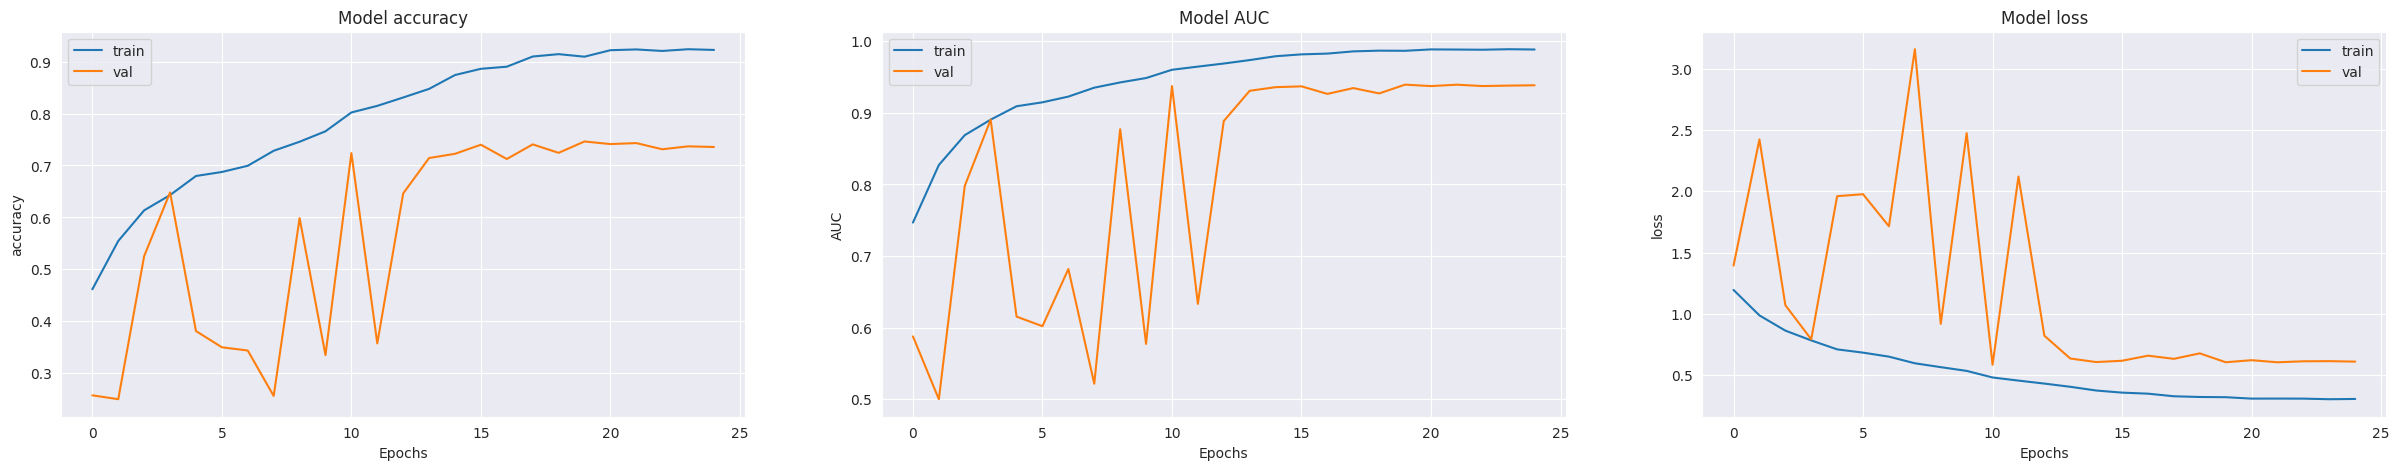

In [40]:
# Plotting the trend of the metrics during training
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "AUC", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [41]:
predictions = model.predict(test_imgs) 
y_pred = np.argmax(predictions, axis = 1)
y_true = np.argmax(test_labels, axis = 1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [42]:
print(classification_report(y_true,y_pred, target_names=CLASSES))
# print(classification_report(test_labels, pred_labels, ))

                  precision    recall  f1-score   support

    MildDemented       0.74      0.85      0.79       400
VeryMildDemented       0.98      1.00      0.99       400
ModerateDemented       0.66      0.73      0.70       400
     NonDemented       0.52      0.38      0.44       400

        accuracy                           0.74      1600
       macro avg       0.73      0.74      0.73      1600
    weighted avg       0.73      0.74      0.73      1600



In [ ]:
cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True,fmt='d')
sns.heatmap(cm, cmap="Reds", annot=True, annot_kws={"size": 10}, fmt='d', xticklabels = CLASSES, yticklabels=CLASSES)
plt.xticks(rotation=0, fontsize=7)
plt.yticks(fontsize=7)

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("SquezeNet Confusion Matrix")
# plt.show()
plt.figure(figsize=(8, 6), dpi=90, facecolor='r', edgecolor='k')


In [ ]:
# Plotting the trend of the metrics during training
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "AUC", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])